# To find the optimum locations for the new homeless shelters

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import geopandas as gpd
import statsmodels.formula.api as smf
from scipy import stats as st
import mpld3 as d3
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Healthcare Data

In [50]:
health = pd.read_csv('Health_Facility_Map.csv')

In [51]:
health.head()

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Operator Zip Code,Cooperator Name,Cooperator Address,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Facility Latitude,Facility Longitude,Facility Location
0,277,Brooklyn-Queens Nursing Home,NH,Residential Health Care Facility - SNF,10/01/1998,2749 Linden Blvd,NaN,Brooklyn,New York,11208,...,11208,NaN,NaN,NaN,NaN,New York,NaN,40.669674,-73.862778,"(40.669674, -73.862778)"
1,318,Primary Care Network,HOSP-EC,Hospital Extension Clinic,10/28/1980,One Fordham Plaza,NaN,Bronx,New York,10458,...,10467,Montefiore Medical Center,111 East 210th Street,NaN,Bronx,New York,10467.0,40.860640,-73.890228,"(40.86064, -73.890228)"
2,333,Methadone Clinic III,HOSP-EC,Hospital Extension Clinic,09/27/2005,211-221 Powell Street,NaN,Brooklyn,New York,11212,...,10701,NaN,NaN,NaN,NaN,New York,NaN,40.669186,-73.903755,"(40.669186, -73.903755)"
3,438,The Children's Aid Society,DTC-EC,Diagnostic and Treatment Center Extension Clinic,06/26/1980,14-32 West 118th Street,NaN,New York,New York,10026,...,10028,NaN,NaN,NaN,NaN,New York,NaN,40.802593,-73.947128,"(40.802593, -73.947128)"
4,441,Lower Eastside Service Center Inc,DTC-EC,Diagnostic and Treatment Center Extension Clinic,10/15/1980,62 East Broadway,NaN,New York,New York,10002,...,10002,NaN,NaN,NaN,NaN,New York,NaN,40.713696,-73.995163,"(40.713696, -73.995163)"


In [52]:
health.columns

Index(['Facility ID', 'Facility Name', 'Short Description', 'Description',
       'Facility Open Date', 'Facility Address 1', 'Facility Address 2',
       'Facility City', 'Facility State', 'Facility Zip Code',
       'Facility Phone Number', 'Facility Fax Number', 'Facility Website',
       'Facility County Code', 'Facility County', 'Regional Office ID',
       'Regional Office', 'Main Site Name', 'Main Site Facility ID',
       'Operating Certificate Number', 'Operator Name', 'Operator Address 1',
       'Operator Address 2', 'Operator City', 'Operator State',
       'Operator Zip Code', 'Cooperator Name', 'Cooperator Address',
       'Cooperator Address 2', 'Cooperator City', 'Cooperator State',
       'Cooperator Zip Code', 'Facility Latitude', 'Facility Longitude',
       'Facility Location'],
      dtype='object')

In [53]:
health = health.drop(['Facility Name', 'Short Description', 'Description',
       'Facility Open Date', 'Facility Address 1', 'Facility Address 2',
       'Facility City', 'Facility State',
       'Facility Phone Number', 'Facility Fax Number', 'Facility Website',
       'Facility County Code', 'Facility County', 'Regional Office ID',
       'Regional Office', 'Main Site Name', 'Main Site Facility ID',
       'Operating Certificate Number', 'Operator Name', 'Operator Address 1',
       'Operator Address 2', 'Operator City', 'Operator State',
       'Operator Zip Code', 'Cooperator Name', 'Cooperator Address',
       'Cooperator Address 2', 'Cooperator City', 'Cooperator State',
       'Cooperator Zip Code', 'Facility Latitude', 'Facility Longitude',
       'Facility Location'],axis=1)

In [54]:
health.head()

,Facility ID,Facility Zip Code
0,277,11208
1,318,10458
2,333,11212
3,438,10026
4,441,10002


In [55]:
len(health)

1084

In [56]:
health = health.groupby(health['Facility Zip Code']).count()
health['ZIP'] = health.index

In [57]:
health['len']=0
for i in range(len(health)):
    health.len[i] = len(health.ZIP[i])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
health.head()

,Facility ID,ZIPCODE
0,11,10001
1,1,10001
2,18,10002
3,16,10003
4,1,10004


In [60]:
health['ZIPCODE'] = health.ZIP
for i in range(len(health)):
    if health.len[i]>5:
        health.ZIPCODE[i] = int(health.ZIP[i].split('-')[0])
    else:
        pass

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [63]:
#del health['ZIP']
#del health['len']
health = health.reset_index(drop=True)

### Importing NYC shapefile

In [8]:
shp = gpd.GeoDataFrame.from_file('ZIP_CODE_040114/ZIP_CODE_040114.shp')

(905410.75604293647,
 1075212.5382562785,
 112386.35181947277,
 280345.45402395498)

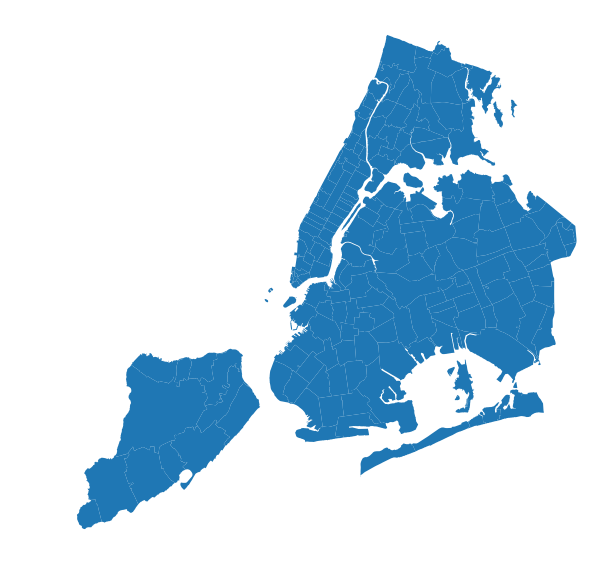

In [9]:
ax = shp.plot(figsize=(10,10))
ax.axis('off')

### Merging Hospital data with shapefile

In [65]:
health_shp = pd.merge(shp, health, left_on=shp.ZIPCODE, right_on = health.ZIPCODE)

In [66]:
health_shp.head()

,ZIPCODE_x,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,Facility ID,ZIPCODE_y
0,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",7,11213
1,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",9,11212
2,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",3,11225
3,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",10,11218
4,11226,0,Brooklyn,106132.0,3.940860e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((994821.4729396403 177865.7178093046,...",13,11226


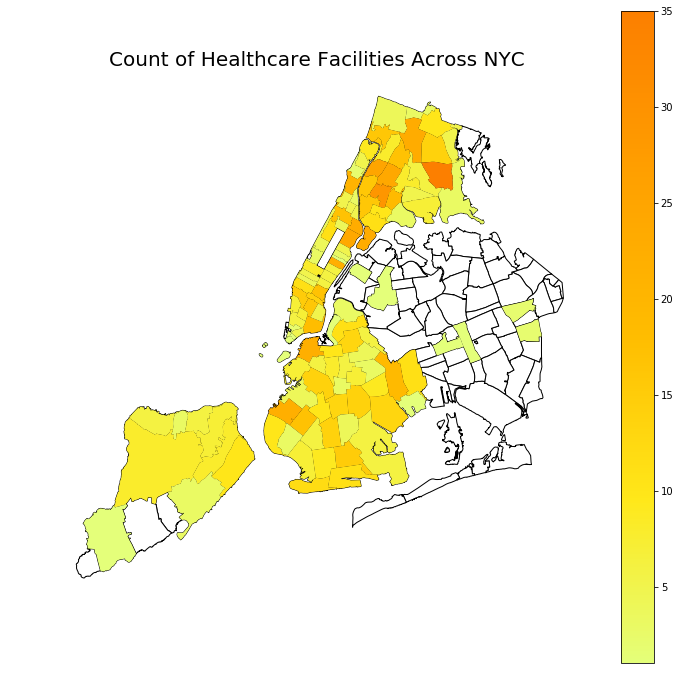

In [69]:
ax = shp.plot(color='w', edgecolor='k', figsize=(12,12))
ax1 = health_shp.plot(ax=ax, column='Facility ID',cmap='Wistia', legend=True)
ax.axis('off')
ax.set_title('Count of Healthcare Facilities Across NYC ', fontsize=20)

### Schools (Charter Schools)

In [77]:
schools = pd.read_csv('schoolFinal.csv')

In [78]:
schools.columns

Index(['BEDS CODE', 'School Name', 'County', 'School Type',
       'Homeless Students', 'Borough', 'Zipcode', 'Latitude', 'Longitude'],
      dtype='object')

In [79]:
schools = schools.drop([ 'School Name', 'County', 'School Type',
       'Homeless Students', 'Borough','Latitude', 'Longitude'],axis=1)

In [86]:
schools = schools.reset_index()
schools.head()

,Zipcode,BEDS CODE
0,10002,1
1,10004,1
2,10006,1
3,10013,1
4,10024,1


In [94]:
schools.Zipcode = schools.Zipcode.astype(str)

In [82]:
schools = schools.groupby(schools.Zipcode).count()

In [92]:
type(schools.Zipcode[0]), type(shp.ZIPCODE[0])

(numpy.int64, str)

### Merging Schools and shapefile

In [95]:
schools_shp = pd.merge(schools, shp, left_on= schools.Zipcode, right_on= shp.ZIPCODE)

In [98]:
schools_shp = gpd.GeoDataFrame(schools_shp)
schools_shp.head()

,Zipcode,BEDS CODE,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,10002,1,10002,0,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.8703228086 207576.7837151289,..."
1,10004,1,10004,0,New York,2187.0,4.002521e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981197.408652395 196571.0816452205, ..."
2,10004,1,10004,0,New York,2187.0,1.202708e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((972696.8446168154 193014.5477478057,..."
3,10004,1,10004,0,New York,2187.0,7.679616e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((977542.4500830621 188447.2783390433,..."
4,10004,1,10004,0,New York,2187.0,6.707080e+05,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((971218.3702115566 190710.8587856293,..."


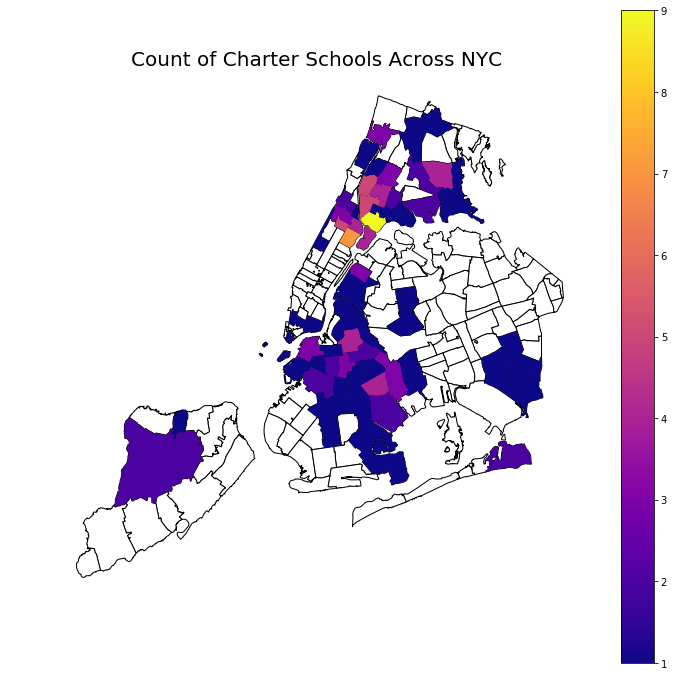

In [99]:
ax = shp.plot(color='w', edgecolor='k', figsize=(12,12))
ax1 = schools_shp.plot(ax=ax, column='BEDS CODE',cmap='plasma', legend=True)
ax.axis('off')
ax.set_title('Count of Charter Schools Across NYC ', fontsize=20)

## MTA and SIRR data

In [150]:
mta = pd.read_csv('stationZip.csv')
sirr = pd.read_csv('sir zipcode.xlsx.csv')

In [151]:
mta.head()

,Unnamed: 0,Station_Longitude,Station_Name,Station_Latitude,lonlat,ZIPCODE
0,0,-73.912034,Ditmars Blvd,40.775036,"(-73.912033999999991, 40.775036)",11105
1,1,-73.912034,Ditmars Blvd,40.775036,"(-73.912033999999991, 40.775036)",11105
2,2,-73.912034,Ditmars Blvd,40.775036,"(-73.912033999999991, 40.775036)",11105
3,3,-73.912034,Ditmars Blvd,40.775036,"(-73.912033999999991, 40.775036)",11105
4,4,-73.917843,Astoria Blvd-Hoyt Av,40.770258,"(-73.917843000000005, 40.770257999999998)",11103


In [152]:
sirr.head()

,Name,Zipcode,Unnamed: 2,Unnamed: 3
0,Annadale,10312.0,"40.54043, 74.17840",NaN
1,Arthur Kill,10309.0,"40.5168, 74.2416",NaN
2,Bay Terrace,10306.0,"40.55658,74.13663",NaN
3,Clifton,10304.0,"40.6215, 74.0715",NaN
4,Dongan Hills,10304.0,"40.5890,74.0959",NaN


In [153]:
mta.columns

Index(['Unnamed: 0', 'Station_Longitude', 'Station_Name', 'Station_Latitude',
       'lonlat', 'ZIPCODE'],
      dtype='object')

In [154]:
mta = mta.drop(['Unnamed: 0', 'Station_Longitude', 'Station_Latitude',
       'lonlat'],axis=1)

In [155]:
type(mta.ZIPCODE[0])

numpy.int64

In [156]:
sirr = sirr.drop(['Unnamed: 2','Unnamed: 3'],axis=1)

In [157]:
sirr = sirr.dropna(subset=['Zipcode '])

In [158]:
sirr['Zipcode'] = sirr['Zipcode '].astype(int)

In [159]:
del sirr['Zipcode ']

In [160]:
sirr = sirr.rename(columns={'Name':'Station_Name','Zipcode':'ZIPCODE' })

In [161]:
#sirr = sirr.reset_index()
sirr.head()

,Station_Name,ZIPCODE
0,Annadale,10312
1,Arthur Kill,10309
2,Bay Terrace,10306
3,Clifton,10304
4,Dongan Hills,10304


In [162]:
len(mta), len(sirr)

(1866, 21)

In [163]:
features= [mta, sirr]
mta_sir = pd.concat(features)

In [164]:
len(mta_sir)

1887

In [165]:
mta_sirr.head()

,Station_Name,ZIPCODE
0,Ditmars Blvd,11105
1,Ditmars Blvd,11105
2,Ditmars Blvd,11105
3,Ditmars Blvd,11105
4,Astoria Blvd-Hoyt Av,11103


In [166]:
mta_sirr = mta_sirr.groupby(mta_sirr.ZIPCODE).count()

In [167]:
mta_sirr = mta_sirr.reset_index()

In [168]:
mta_sirr.head()

,ZIPCODE,Station_Name
0,83,20
1,10001,51
2,10002,15
3,10003,30
4,10004,16


### Merging subway data with shapefile

In [169]:
mta_sirr.ZIPCODE = mta_sirr.ZIPCODE.astype(str)

In [170]:
mta_shp = pd.merge(mta_sirr, shp, left_on = mta_sirr.ZIPCODE, right_on=shp.ZIPCODE)

In [171]:
mta_shp.head()

,ZIPCODE_x,Station_Name,ZIPCODE_y,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,10001,51,10001,0,New York,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,10002,15,10002,0,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.8703228086 207576.7837151289,..."
2,10003,30,10003,0,New York,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469142139 207048.1263078749, ..."
3,10004,16,10004,0,New York,2187.0,4.002521e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981197.408652395 196571.0816452205, ..."
4,10004,16,10004,0,New York,2187.0,1.202708e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((972696.8446168154 193014.5477478057,..."


In [172]:
mta_shp = gpd.GeoDataFrame(mta_shp)

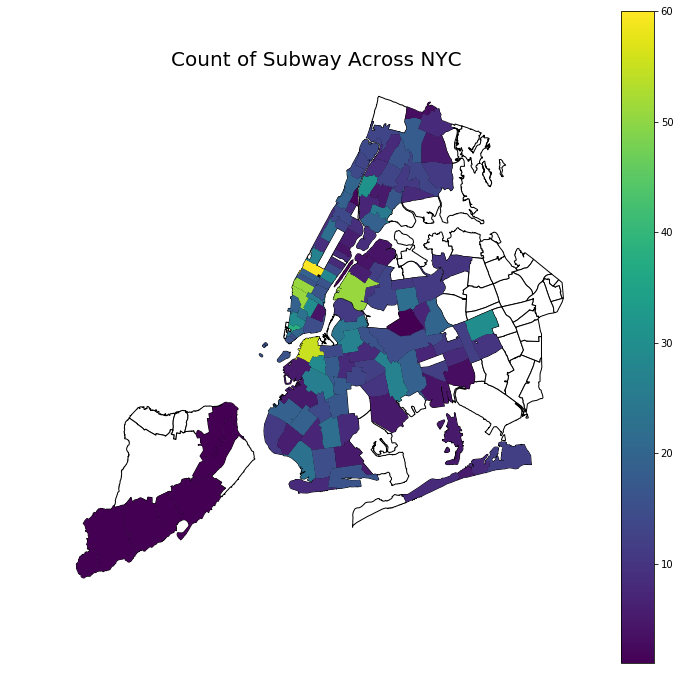

In [173]:
ax = shp.plot(color='w', edgecolor='k', figsize=(12,12))
ax1 = mta_shp.plot(ax=ax, column='Station_Name',cmap='viridis', legend=True)
ax.axis('off')
ax.set_title('Count of Subway Across NYC ', fontsize=20)

### Rent data

In [174]:
rent = pd.read_csv('Census tract data.csv')

In [175]:
zdata= pd.read_csv('ZIP_TRACT_122016.csv')

In [179]:
zdata.head()

,Unnamed: 0,ZIP,TRACT,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
0,0,501,36103158607,0.000000,1.000000,0.000000,1.000000
1,1,601,72001956600,0.136735,0.358911,0.347222,0.154270
2,2,601,72001956700,0.859996,0.636139,0.652778,0.842387
3,3,601,72001956300,0.003269,0.004950,0.000000,0.003343
4,4,602,72003430300,0.037744,0.272500,0.315789,0.055036


In [177]:
rent.head()

,FID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,INTPTLAT10,INTPTLON10,State,COUNTY,HH_COUNT,...,MSMOC_TOT_,TAX_RET,Avg_TransC,REtaxperow,DISP_INC,energy_cos,REtax_ACS,AVG_TTL,LOCALNAME,Shape_Area
0,0,34,17,32400,34017032400,40.792844,-74.013482,New Jersey,Hudson County,2187,...,22740,2264.889916,4145.566539,4966.370331,12232.00950,1773.280152,7735,5007.444405,West New York Town,0.000036
1,1,34,17,10100,34017010100,40.691559,-74.110913,New Jersey,Hudson County,2255,...,27804,2363.430717,5969.286255,4490.984109,22077.84024,1876.844806,7917,6146.888195,Bayonne City,0.000106
2,2,34,17,10200,34017010200,40.682103,-74.104573,New Jersey,Hudson County,1218,...,28068,1260.718928,6014.489564,3339.224580,20488.60531,2167.175106,7692,6193.436421,Bayonne City,0.000031
3,3,34,17,10300,34017010300,40.672439,-74.081016,New Jersey,Hudson County,1093,...,22620,1229.562591,4798.787758,3793.386763,15514.61337,2163.964082,7831,4941.564294,Bayonne City,0.000108
4,4,34,17,10400,34017010400,40.670599,-74.089940,New Jersey,Hudson County,1571,...,20724,2209.874484,7611.970058,4478.110461,35131.00534,2114.480847,7918,7838.446154,Bayonne City,0.000234


In [178]:
rent.columns

Index(['FID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'INTPTLAT10',
       'INTPTLON10', 'State', 'COUNTY', 'HH_COUNT', 'OHU_OWN', 'OHU_RENT',
       'PERC_OWN', 'PERC_RENT', 'MHI', 'MED_VAL', 'HOUSINGCOS', 'MCR_ANNUAL',
       'MSMOC_TOT_', 'TAX_RET', 'Avg_TransC', 'REtaxperow', 'DISP_INC',
       'energy_cos', 'REtax_ACS', 'AVG_TTL', 'LOCALNAME', 'Shape_Area'],
      dtype='object')

In [180]:
rent = rent.drop([ 'STATEFP10', 'COUNTYFP10', 'INTPTLAT10',
       'INTPTLON10', 'State', 'COUNTY', 'HH_COUNT', 'OHU_OWN', 'OHU_RENT',
       'PERC_OWN', 'PERC_RENT', 'MED_VAL', 'HOUSINGCOS', 'MCR_ANNUAL',
       'MSMOC_TOT_', 'TAX_RET', 'Avg_TransC', 'REtaxperow', 'DISP_INC',
       'energy_cos', 'REtax_ACS', 'AVG_TTL', 'LOCALNAME', 'Shape_Area'],axis=1)

In [181]:
rent.head()

,FID,TRACTCE10,GEOID10,MHI
0,0,32400,34017032400,37234
1,1,10100,34017010100,53614
2,2,10200,34017010200,54020
3,3,10300,34017010300,43101
4,4,10400,34017010400,68368


In [182]:
mhi_data = pd.merge(rent, zdata, left_on=rent.GEOID10, right_on=zdata.TRACT)

In [183]:
mhi_data.head()

,FID,TRACTCE10,GEOID10,MHI,Unnamed: 0,ZIP,TRACT,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
0,0,32400,34017032400,37234,8971,7093,34017032400,0.084513,0.098403,0.107687,0.087397
1,1,10100,34017010100,53614,8399,7002,34017010100,0.078836,0.059420,0.090999,0.078735
2,2,10200,34017010200,54020,8401,7002,34017010200,0.041207,0.054106,0.052094,0.043030
3,3,10300,34017010300,43101,8402,7002,34017010300,0.042147,0.053623,0.043851,0.043030
4,3,10300,34017010300,43101,9297,7305,34017010300,0.000000,0.000823,0.000000,0.000037


In [184]:
mhi_data.columns

Index(['FID', 'TRACTCE10', 'GEOID10', 'MHI', 'Unnamed: 0', 'ZIP', 'TRACT',
       'RES_RATIO', 'BUS_RATIO', 'OTH_RATIO', 'TOT_RATIO'],
      dtype='object')

In [186]:
mhi_data = mhi_data.drop(['TRACTCE10', 'GEOID10', 'Unnamed: 0', 'TRACT',
       'RES_RATIO', 'BUS_RATIO', 'OTH_RATIO', 'TOT_RATIO'],axis=1)

In [187]:
mhi_data.head()

,FID,MHI,ZIP
0,0,37234,7093
1,1,53614,7002
2,2,54020,7002
3,3,43101,7002
4,3,43101,7305


In [188]:
mhi_data = mhi_data.groupby(mhi_data.ZIP).mean()
mhi_data = mhi_data.reset_index()

In [189]:
mhi_data.head()

,ZIP,FID,MHI
0,501,4351.0,73889.0
1,6018,5078.0,46417.0
2,6021,5061.0,72000.0
3,6024,5078.0,46417.0
4,6031,5082.0,64755.5


### merging standardized rent data with shapefile

In [191]:
mhi_data.ZIP= mhi_data.ZIP.astype(str)

In [192]:
mhi_shp = pd.merge(shp, mhi_data, left_on= shp.ZIPCODE, right_on=mhi_data.ZIP )

In [193]:
mhi_shp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,ZIP,FID,MHI
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",11436,3649.181818,62243.272727
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",11213,2179.772727,34721.000000
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212,2649.666667,34238.633333
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",11225,2234.555556,37717.222222
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",11218,2460.392857,45154.964286


In [199]:
len(mhi_shp)

248

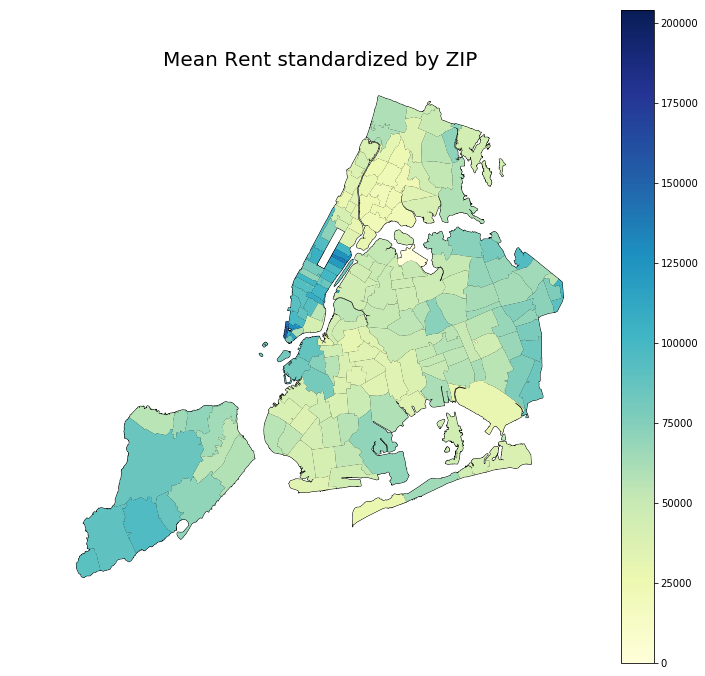

In [194]:
ax = shp.plot(color='w', edgecolor='k', figsize=(12,12))
ax1 = mhi_shp.plot(ax=ax, column='MHI',cmap='YlGnBu', legend=True)
ax.axis('off')
ax.set_title('Mean Rent standardized by ZIP', fontsize=20)

## Merging all the datasets

In [ ]:
# health_shp, schools_shp, mta_shp, mhi_shp

In [196]:
health_schools = pd.merge(health_shp, schools_shp, left_on=health_shp.ZIPCODE_x, right_on=schools_shp.ZIPCODE)

In [197]:
health_schools.head()

,ZIPCODE_x,BLDGZIP_x,PO_NAME_x,POPULATION_x,AREA_x,STATE_x,COUNTY_x,ST_FIPS_x,CTY_FIPS_x,URL_x,...,POPULATION_y,AREA_y,STATE_y,COUNTY_y,ST_FIPS_y,CTY_FIPS_y,URL_y,SHAPE_AREA_y,SHAPE_LEN_y,geometry_y
0,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
1,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,...,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
2,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,...,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
3,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,...,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."
4,11226,0,Brooklyn,106132.0,3.940860e+07,NY,Kings,36,047,http://www.usps.com/,...,106132.0,3.940860e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((994821.4729396403 177865.7178093046,..."


In [198]:
len(health_schools)

81

In [200]:
hs_mta = pd.merge(health_schools, mta_shp, left_on= health_schools.ZIPCODE, right_on=mta_shp.ZIPCODE_x)

In [202]:
len(hs_mta)

133

In [212]:
final_data = pd.merge(hs_mta, mhi_shp, left_on= hs_mta.ZIPCODE, right_on= mhi_shp.ZIPCODE)

In [204]:
len(final_data)

349

In [205]:
final_data.columns

Index(['ZIPCODE_x_x', 'BLDGZIP_x', 'PO_NAME_x', 'POPULATION_x', 'AREA_x',
       'STATE_x', 'COUNTY_x', 'ST_FIPS_x', 'CTY_FIPS_x', 'URL_x',
       'SHAPE_AREA_x', 'SHAPE_LEN_x', 'geometry_x', 'Facility ID',
       'ZIPCODE_y_x', 'Zipcode', 'BEDS CODE', 'ZIPCODE_x', 'BLDGZIP_y',
       'PO_NAME_y', 'POPULATION_y', 'AREA_y', 'STATE_y', 'COUNTY_y',
       'ST_FIPS_y', 'CTY_FIPS_y', 'URL_y', 'SHAPE_AREA_y', 'SHAPE_LEN_y',
       'geometry_y', 'ZIPCODE_x_y', 'Station_Name', 'ZIPCODE_y_y', 'BLDGZIP_x',
       'PO_NAME_x', 'POPULATION_x', 'AREA_x', 'STATE_x', 'COUNTY_x',
       'ST_FIPS_x', 'CTY_FIPS_x', 'URL_x', 'SHAPE_AREA_x', 'SHAPE_LEN_x',
       'geometry_x', 'ZIPCODE_y', 'BLDGZIP_y', 'PO_NAME_y', 'POPULATION_y',
       'AREA_y', 'STATE_y', 'COUNTY_y', 'ST_FIPS_y', 'CTY_FIPS_y', 'URL_y',
       'SHAPE_AREA_y', 'SHAPE_LEN_y', 'geometry_y', 'ZIP', 'FID', 'MHI'],
      dtype='object')

In [214]:
final_data = final_data.drop([
       'ZIPCODE_y_x', 'Zipcode', 'ZIPCODE_x', 'BLDGZIP_y',
       'PO_NAME_y', 'POPULATION_y', 'AREA_y', 'STATE_y', 'COUNTY_y',
       'ST_FIPS_y', 'CTY_FIPS_y', 'URL_y', 'SHAPE_AREA_y', 'SHAPE_LEN_y',
       'geometry_y', 'ZIPCODE_x_y', 'ZIPCODE_y_y', 'BLDGZIP_x',
       'PO_NAME_x', 'POPULATION_x', 'AREA_x', 'STATE_x', 'COUNTY_x',
       'ST_FIPS_x', 'CTY_FIPS_x', 'URL_x', 'SHAPE_AREA_x', 'SHAPE_LEN_x',
       'geometry_x', 'ZIPCODE_y', 'ZIP', 'FID'],axis=1)

In [216]:
final_data = final_data.rename(columns={'ZIPCODE_x_x': 'ZIPCODE'})

In [236]:
final_data.head()

,ZIPCODE,Facility ID,BEDS CODE,Station_Name,MHI,score
0,11213,7,1,13,34721.000000,3
1,11212,9,4,10,34238.633333,5
2,11225,3,1,18,37717.222222,3
3,11218,10,1,14,45154.964286,5
4,11226,13,1,17,39449.241379,5


In [237]:
min(final_data['Station_Name']), max(final_data['Station_Name'])

(5, 55)

In [224]:
final_data.ZIPCODE =  final_data.ZIPCODE.astype(int)

In [226]:
final_data['score']=0

In [229]:
for i in range(len(final_data)):
    if 8>int(final_data['Facility ID'][i])>=1 :
        final_data.score[i]+=1
    elif 15>int(final_data['Facility ID'][i])>=8:
        final_data.score[i]+=2
    elif 22>=int(final_data['Facility ID'][i])>=15:
        final_data.score[i]+=3
    elif 29>=int(final_data['Facility ID'][i])>=22:
        final_data.score[i]+=4
    elif 35>=int(final_data['Facility ID'][i])>=29:
        final_data.score[i]+=5
    else:
        final_data.score[i]+=0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_

In [232]:
for i in range(len(final_data)):
    if 39200>int(final_data['MHI'][i])>=21000 :
        final_data.score[i]+=1
    elif 57200>int(final_data['MHI'][i])>=39200:
        final_data.score[i]+=2
    elif 75200>=int(final_data['MHI'][i])>=57200:
        final_data.score[i]+=3
    elif 93200>=int(final_data['MHI'][i])>=75200:
        final_data.score[i]+=4
    elif 111300>=int(final_data['MHI'][i])>=93200:
        final_data.score[i]+=5
    else:
        final_data.score[i]+=0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: 

In [235]:
for i in range(len(final_data)):
    if 3>int(final_data['BEDS CODE'][i])>=1 :
        final_data.score[i]+=1
    elif 5>int(final_data['BEDS CODE'][i])>=3:
        final_data.score[i]+=2
    elif 7>=int(final_data['BEDS CODE'][i])>=5:
        final_data.score[i]+=3
    elif 9>=int(final_data['BEDS CODE'][i])>=7:
        final_data.score[i]+=4
    elif 10>=int(final_data['BEDS CODE'][i])>=9:
        final_data.score[i]+=5
    else:
        final_data.score[i]+=0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: S

In [238]:
for i in range(len(final_data)):
    if 12>int(final_data['Station_Name'][i])>=5 :
        final_data.score[i]+=1
    elif 24>int(final_data['Station_Name'][i])>=12:
        final_data.score[i]+=2
    elif 36>=int(final_data['Station_Name'][i])>=24:
        final_data.score[i]+=3
    elif 48>=int(final_data['Station_Name'][i])>=36:
        final_data.score[i]+=4
    elif 56>=int(final_data['Station_Name'][i])>=48:
        final_data.score[i]+=5
    else:
        final_data.score[i]+=0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: 

In [239]:
final_data.head()

,ZIPCODE,Facility ID,BEDS CODE,Station_Name,MHI,score
0,11213,7,1,13,34721.000000,5
1,11212,9,4,10,34238.633333,6
2,11225,3,1,18,37717.222222,5
3,11218,10,1,14,45154.964286,7
4,11226,13,1,17,39449.241379,7


In [241]:
shp.ZIPCODE = shp.ZIPCODE.astype(int)

In [242]:
final_plot = pd.merge(shp, final_data, left_on=shp.ZIPCODE, right_on= final_data.ZIPCODE)

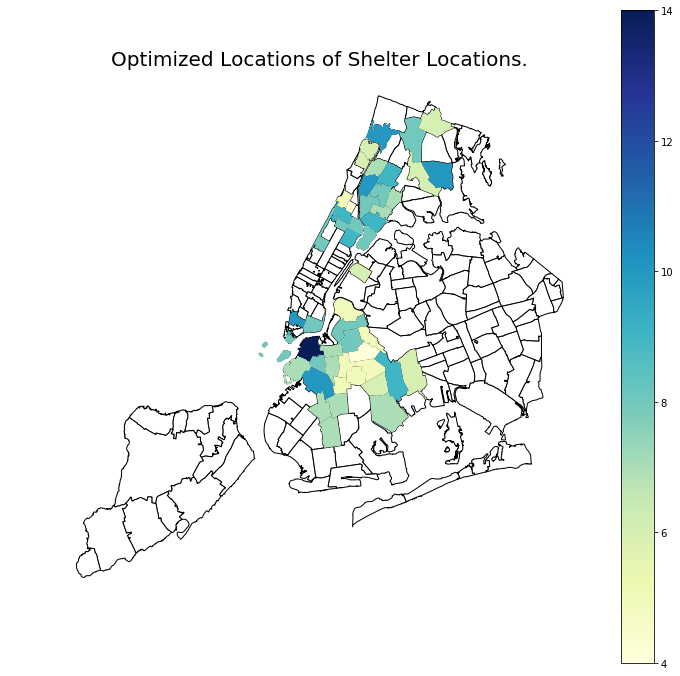

In [245]:
ax = shp.plot(color='w', edgecolor='k', figsize=(12,12))
ax1 = final_plot.plot(ax=ax, column='score',cmap='YlGnBu', legend=True)
ax.axis('off')
ax.set_title('Optimized Locations of Shelter Locations.', fontsize=20)